# Imports


In [1]:
!pip install dijkstar


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
# Import opencv for computer vision
import cv2 
# Import matplotlib to visualize an image
from matplotlib import pyplot as plt
from __future__ import print_function
import sys
from random import randint
import cv2.aruco as aruco
import math
from PIL import Image

from dijkstar import Graph, find_path
from IPython.display import display

import networkx as nx
import matplotlib.pyplot as plt

# Computer Vision


## Past attempts:

Potential solutions:
1. Using Tensorflow
https://www.youtube.com/watch?v=yqkISICHH-U

2. Using MultiTracker OpenCV
https://learnopencv.com/multitracker-multiple-object-tracking-using-opencv-c-python/

### Using MultiTracker OpenCV


Start by creating a single object tracker
- below doesnt work

Read the first frame of livestream
* May need to modify

Locate objects in the first frame

Check out
https://www.youtube.com/watch?v=8ktcGQ-XreQ

Perhaps use YOLOv5:
https://blog.paperspace.com/train-yolov5-custom-data/


https://blog.roboflow.com/how-to-train-yolov5-on-a-custom-dataset/


## 1. Setting up Aruco

### Markers detected in real time:


Code referenced from:
https://docs.opencv.org/4.8.0/d5/dae/tutorial_aruco_detection.html

In [2]:
import cv2
from cv2 import aruco

cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
    parameters = aruco.DetectorParameters()
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
    # print("Corners", corners)
    # # print("1 idx", corners[0])
    # print("2 idx", corners[0][0])
    # print("3 idx", corners[0][0][1])
    # print("4 idx", corners[1][0])


    if np.all(ids is not None):
        for i in range(0, len(ids)):
            #rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners[i], 0.02, camera_matrix, distortion_coefficients)
            aruco.drawDetectedMarkers(frame, corners, ids)
            #cv2.drawFrameAxes(frame, camera_matrix, distortion_coefficients, rvec, tvec, 0.02)

    cv2.imshow('frame', frame)

    key = cv2.waitKey(3) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


### Getting marker coordinates


Thymio: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;index 0
<br>
Obstacles:&nbsp;&nbsp;&nbsp;indicies 1-6
<br>
Goal:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;index 7

In [10]:
def current_photo():
    cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)
    ret, frame = cap.read()
    cv2.imwrite('images/current.jpg', frame)
    cap.release()
    
    

The following functions below retrieve the first photo, and utilize it to locate the coordinates of the markers.


In [11]:
def get_Thymio():
    img_path = 'images/current.jpg'
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
 
    # Get thymio at idx 0  
    idx_back = np.where(ids == 0)[0][0]
    idx_fowards = np.where(ids == 1)[0][0]
    idx = [idx_back, idx_fowards]
    coords = [corners[i].tolist() for i in idx]  
    
    center = []
    for i in coords:
        # Get center coordinates to return
        x1 = i[0][0][0]
        y1 = i[0][0][1]
        x2 = i[0][2][0]
        y2 = i[0][2][1]

        x_center = (x1 + x2) / 2
        y_center = (y1 + y2) / 2
    
        center.append([x_center, y_center])
    return center
    
    


In [12]:
def get_goal():
    img_path = 'images/current.jpg'
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
    
    # If aruco markers are detected:
    # if np.all(ids is not None):
      #  output_image = gray.copy()
        #aruco.drawDetectedMarkers(output_image,corners) 
                    
    # Get goal at idx 7  
    idx = np.where(ids == 7)[0][0]
    coords = corners[idx]
    
      
    
    # Get center coordinates to return
    x1 = coords[0][0][0]
    y1 = coords[0][0][1]
    x2 = coords[0][2][0]
    y2 = coords[0][2][1]
    
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    
    center = [x_center, y_center]
    
    return center

In [13]:
def get_obst():
    img_path = 'images/current.jpg'
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Change grayscale
    aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)  # Use 5x5 dictionary to find markers
    parameters = aruco.DetectorParameters()  
    detector = aruco.ArucoDetector(aruco_dict, parameters)

    corners, ids, rejected_img_points = detector.detectMarkers(gray)
    
    # If aruco markers are detected:
    # if np.all(ids is not None):
      #  output_image = gray.copy()
        #aruco.drawDetectedMarkers(output_image,corners) 
                    
    # Get obstacles at idx that is not Thymio or goal 
    idx = np.where((ids != 0) & (ids != 7) & (ids != 1))[0]
    coord = [corners[i].tolist() for i in idx]
    print("Coord",coord)
    id = ids[idx]
    print("ID", id)
    
    coords_list = []

    for i in coord:    
        ul_x = i[0][0][0]
        ul_y = i[0][0][1]

        ur_x = i[0][1][0]
        ur_y = i[0][1][1]

        br_x = i[0][2][0]
        br_y = i[0][2][1]

        bl_x = i[0][3][0]
        bl_y = i[0][3][1]

        coords_list.append([ul_x, ul_y, ur_x, ur_y, bl_x, bl_y, br_x, br_y])
        
    # Sort coords based on id
    coords = [x for y, x in sorted(zip(id, coords_list))]
    return coords

In [14]:
# obstacle_coord = get_obst()
# print(obstacle_coord)

# Global path Planning

## Node map

In [15]:

#various distance function outputing the distance between 2 coordinates depending on their type

def distance(node1,node2):
    distance=math.sqrt((node_coord_x[node2]-node_coord_x[node1])**2+(node_coord_y[node2]-node_coord_y[node1])**2)
    distance=round(distance,2)
    return distance
def distance_goal_node(goal,node):
    distance=math.sqrt((goal_coord_x[goal]-node_coord_x[node])**2+(goal_coord_y[goal]-node_coord_y[node])**2)
    distance=round(distance,2)
    return distance

def distance_node_goal(node,goal):
    distance=math.sqrt((goal_coord_x[goal]-node_coord_x[node])**2+(goal_coord_y[goal]-node_coord_y[node])**2)
    distance=round(distance,2)
    return distance

#creating the nodes from the corner. If the corner is on the side of the x axis, the middle point between x=0 and x_corner is taken
#if the corner is on the opposite side, a calculation is done to find the middle point between the botttom of the image and the obstacle

def node_creation():
    for obstacle in range(obs_nbr):
        for corner_high in range(2):
            node_coord_y.append(obstacle_coord[obstacle][(2*corner_high)+1]/2)
            node_coord_x.append(obstacle_coord[obstacle][(2*corner_high)])
        for corner_low in range(2):
            node_coord_y.append(max_coord_y-((max_coord_y-obstacle_coord[obstacle][(2*corner_low)+5])/2))
            node_coord_x.append(obstacle_coord[obstacle][(2*corner_low)+4])

def draw_graph(graph_data):
    # Creating a graph using networkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for node, edges in graph_data.items():
        G.add_node(node)
        for neighbor, weight in edges.items():
            G.add_edge(node, neighbor, weight=weight)

    # Draw the graph
    pos = nx.spring_layout(G)  # Node positions for a clearer appearance
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="skyblue", font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    # Display the graph
    plt.show()

#creation of all the links between the nodes following the pattern presented above

def connect_nodes(obs_nbr):     
    for nb_node in range(obs_nbr*4-1):
        if nb_node % 2 == 0:
            graph.add_edge(nb_node, nb_node + 1, distance(nb_node, nb_node + 1))
            if nb_node > 3:
                graph.add_edge(nb_node, nb_node -3, distance(nb_node, nb_node -3))
                if nb_node % 4 == 0:
                    graph.add_edge(nb_node, nb_node - 1, distance(nb_node, nb_node - 1))
                else:
                    graph.add_edge(nb_node, nb_node - 5, distance(nb_node, nb_node - 5))
        else:
            graph.add_edge(nb_node, nb_node - 1, distance(nb_node, nb_node - 1))
            if nb_node < (obs_nbr-1)*4:
                graph.add_edge(nb_node, nb_node + 3, distance(nb_node, nb_node + 3))
                if (nb_node-1) % 4 == 0:
                    graph.add_edge(nb_node, nb_node + 5, distance(nb_node, nb_node + 5))
                else:
                    graph.add_edge(nb_node, nb_node + 1, distance(nb_node, nb_node + 1))



## Localisation of the Thymio and goal on the node map and creation of the links

In [16]:


def localisation(object):

    column=0
    break_flag=0
    
    for obstacle in range(obs_nbr):
        for corner in range(2):
            if goal_coord_x[object]<obstacle_coord[obstacle][(2*corner)]:
                break_flag=1
                break
            column+=1
            
        if break_flag==1:
            break
            
    print(column)
    if column % 2 == 0:   #even column means no obstacles, 4 links to add. If on the first or last column, only 2 to the nearest obstacle
    
        if column < 2 * obs_nbr:
            graph.add_edge(object + offset, 2 * column, distance_goal_node(object, 2 * column))
            graph.add_edge(2 * column, object + offset, distance_node_goal(2 * column, object))

            graph.add_edge(object + offset, 2 * column + 2, distance_goal_node(object, 2 * column + 2))
            graph.add_edge(2 * column + 2, object + offset, distance_node_goal(2 * column + 2, object))
    
        if column > 0:
            graph.add_edge(object + offset, 2 * column - 1, distance_goal_node(object, 2 * column - 1))
            graph.add_edge(2 * column - 1, object + offset, distance_node_goal(2 * column - 1, object))

            graph.add_edge(object + offset, 2 * column - 3, distance_goal_node(object, 2 * column - 3))
            graph.add_edge(2 * column - 3, object + offset, distance_node_goal(2 * column - 3, object))
            
  
    else:   #odd column, we need to check if we are above or under and obstacle, and then generate the 2 link 
        
        if goal_coord_y[object] < obstacle_coord[math.floor((column - 1) / 2)][1]:
            graph.add_edge(object + offset, (2 * column) - 1, distance_goal_node(object, (2 * column) - 1))
            graph.add_edge((2 * column) - 1, object + offset, distance_node_goal((2 * column) - 1, object))

            graph.add_edge(object + offset, (2 * column) - 2, distance_goal_node(object, (2 * column) - 2))
            graph.add_edge((2 * column) - 2, object + offset, distance_node_goal((2 * column) - 2, object))
        else:
            graph.add_edge(object + offset, (2 * column), distance_goal_node(object, (2 * column)))
            graph.add_edge((2 * column), object + offset, distance_node_goal((2 * column), object))

            graph.add_edge(object + offset, (2 * column) + 1, distance_goal_node(object, (2 * column) + 1))
            graph.add_edge((2 * column) + 1, object + offset, distance_node_goal((2 * column) + 1, object))


            


## global navigation function

In [17]:
def global_navigation():
    current_photo()             
    global center_thymio 
    center_thymio  = get_Thymio()  
    global center_goal
    center_goal = get_goal()
    global obstacle_coord
    obstacle_coord = get_obst()
    global obs_nbr                     #amount of obstacle in the arena
    obs_nbr = len(obstacle_coord)
    global node_coord_x                #x coordinate of the node, arranged in the sequence presented above
    node_coord_x=[]      
    global node_coord_y                 #y coordinates of the node, arranged in the sequence presented above
    node_coord_y=[]
    
    global max_coord_y
    max_coord_y=480

    global graph
    graph = Graph()                #node map will be stored here
    global goal_coord_x
    goal_coord_x=[center_thymio[0][0],center_goal[0]]   
    global goal_coord_y
    goal_coord_y=[center_thymio[0][1],center_goal[1]]
    global offset
    offset=obs_nbr*4
    
    node_creation()   #creation of the nodes
    connect_nodes(obs_nbr)       #creation of the nodes map
    localisation(0)             #adding thymio (0) and goal(1) on the map
    localisation(1)
    
    global shortest_path
    shortest_path = find_path(graph, offset, offset+1)   #dijstra algorithm to find the shortest path on the node map
    shortest_path[0].append(offset+2)    #flag to indicate the end of the navigation (goal attained)

    global current_goal
    current_goal=1                  #indicate the index of the shortest_path list the robot should follow

    node_coord_x.append(center_goal[0])     #coordinates of the goal and finish flag
    node_coord_y.append(center_goal[1])
    node_coord_x.append(center_goal[0])
    node_coord_y.append(center_goal[1])
    
    draw_graph(graph)
    print(shortest_path)

    

In [18]:
def global_navigation_real_time(corners,ids, center_thymio,center_goal,obstacle_coord):

    #same as above but without recomputing the nodes coordinates. The path is rebuilt with the new position of thymio after kidnapping
    
    global max_coord_y
    max_coord_y=480

    global graph
    graph = Graph()
    print(center_thymio)
    global goal_coord_x
    goal_coord_x[0]=center_thymio[0][0] 
    global goal_coord_y
    goal_coord_y[0]=center_thymio[0][1]

    
    connect_nodes(obs_nbr)
    print(graph)
    draw_graph(graph)
    localisation(0)
    localisation(1)
    print(graph)
    draw_graph(graph)
    
    global shortest_path
    shortest_path=0
    shortest_path = find_path(graph, offset, offset+1)
    shortest_path[0].append(offset+2)
    print(shortest_path)
    global current_goal
    current_goal=1
    
    
    draw_graph(graph)
    print(shortest_path)
    

    

## Movement


### PID and P Controller variables


In [19]:
thymio_angle=0     #thymio angle relative to -x
goal_vector=[0,0]   #vector between thymio and its current goal
goal_angle=0

error_angle=0.0    #angular error between thymio orientation and goal_vector

# adjust later
distance_to_goal=0
distance_threshold=30   #once under this distance from a node, switch to next node
speed_threshold=50      #once under this distance from a node, slow down

iteration_period=0
last_error_angle=0


motor_command = [0,0,0]   #motor command, [left, right]
motor_command_max=200
transversal_speed=0
rotation_speed=0
total_speed=[0,0]

proximity_gain=0.1     
proximity_threshold=250         
proximity_command=[0,0]
proximity_speed=25         #offset speed during local avoidance

goal_status=0

#PID controller for angular speed

Kp=2
Kd=0.01
Ki=0.01
derivative=0
integral=0
integral_max=50;

#P controller for transversal speed

Kp2=350




## PID and P controller and local avoidance

In [20]:
def get_angle(y,x):
    angle=math.degrees(math.atan2(y,x))
    return angle



def controller(center,current_goal, time_period, proximity):
    
    global error_angle, integral, derivative, motor_command, motor_command_max, transversal_speed, proximity_command, proximity_speed, proximity_threshold, proximity_gain
    
    #--------------------------------- Angle and distance computation----------------------------------------
    
    goal_vector=[center[0][0]-node_coord_x[shortest_path[0][current_goal]],center[0][1]-node_coord_y[shortest_path[0][current_goal]]]  #vector between thymio and goal

    goal_angle=get_angle(goal_vector[1],goal_vector[0])  #angle from horizontal of goal_vector

   
                         
    thymio_vector=[center[0][0]-center[1][0],center[0][1]-center[1][1]]
                    
    thymio_angle=get_angle(thymio_vector[1],thymio_vector[0])     #angle of thymio relative to -x

    last_error_angle=error_angle

                         
    error_angle=thymio_angle-goal_angle #error between direction of thymio and goal_vector
    if error_angle>180:  #converstion from 0-360 to -180-180
        error_angle-=360

    
    distance_to_goal=distance=math.sqrt((center[0][0]-node_coord_x[shortest_path[0][current_goal]])**2+(center[0][1]-node_coord_y[shortest_path[0][current_goal]])**2)
    #distance between the thymio and the current goal

    

     #--------------------------------- Derivative, integrale and speeds computation----------------------------------------

    
    
    derivative=(error_angle-last_error_angle)/time_period  #derivative of the angular error
    
    integral+=error_angle*time_period #integral of the angular error
    
    if abs(integral)>integral_max:
        integral=integral_max*(integral/abs(integral))   #anti windup mechanism 

    transversal_speed=(1/(abs(error_angle)+2))*Kp2 #transversal speed lower if the error is big and faster if the error is low (+2 to avoid the asymptote at 0)
    
    if distance_to_goal<speed_threshold:    # Make the robot go slower if close to the goal
        transversal_speed=transversal_speed/2
    
    rotation_speed=error_angle*(Kp+Ki*integral+Kd*derivative) #PID regulator for rotation speed

    

     #--------------------------------- Local avoidance with proximity sensors----------------------------------------

    

    if (proximity[0]+proximity[1]+proximity[2]+proximity[3]+proximity[4])>proximity_threshold:   #local avoidance, increase speed on one motor to avoid an obstacle
        if proximity[3]+proximity[4]>proximity[0]+proximity[1]+proximity[2]:   #detection of which side is the obstacle
            proximity_command[1]=proximity_gain*(proximity[3]+proximity[4])
            proximity_speed=25                               #offset speed to compensate that the transversal speed will be very low if the error is big during the avoidance
    
        else:
            proximity_command[0]=proximity_gain*(proximity[0]+proximity[1]+proximity[2])
            proximity_speed=25
    else:
        proximity_command=[0,0]
        proximity_speed-=1                            #fading offset speed after local avoidance to gain a bit of distance from the obstacle
        if proximity_speed<0:
            proximity_speed=0


    

     #---------------------------------Computing total motor speed----------------------------------------


    
    
    transversal_speed+=proximity_speed

    
    total_speed[0] = -rotation_speed+transversal_speed+proximity_command[0] #differential speed for both motor
    total_speed[1] = rotation_speed+transversal_speed+proximity_command[1]


    if abs(motor_command[0])>motor_command_max: 
        motor_command[0]=motor_command_max*(motor_command[0]/abs(motor_command[0]))  #command limitation if it goes above the max allowed, with the right sign

    if abs(motor_command[1])>motor_command_max:
        motor_command[1]=motor_command_max*(motor_command[1]/abs(motor_command[1]))  #command limitation if it goes above the max allowed, with the right sign


    if distance_to_goal<distance_threshold:    #Switch to the next node if close enough to the current goal
        total_speed[0]=0
        total_speed[1]=0
        motor_command[2]=0                     #flag used to communicate to the main that the goal is attained
        integral=0

   
    motor_command[0]=round(total_speed[0])
    motor_command[1]=round(total_speed[1])
                            
    #---------------------------------Monitoring----------------------------------------  
    
    print_statements = [error_angle, transversal_speed, thymio_angle, derivative, proximity_speed, integral]
    print_statements[0] = transversal_speed
    print_statements[1] = rotation_speed
    print_statements[2] = shortest_path[0]
    print_statements[3] = shortest_path[0][current_goal]
    print_statements[4] = current_goal

    print("transversal speed")
    print(print_statements[0])
    print("angular speed")
    print(print_statements[1])
    print("Path")
    print(print_statements[2])
    print("Next node")
    print(print_statements[3])
    print("current goal")
    print(print_statements[4])
    return motor_command

## Get the coordinates in real time

## Thymio

In [21]:
def thymio_real_time(corners, ids):
    # Get thymio at idx 0 and 1
    idx_back = np.where(ids == 0)[0]
    idx_fowards = np.where(ids == 1)[0]

    if idx_back.size > 0 and idx_fowards.size > 0:
        idx_back = idx_back[0]
        idx_fowards = idx_fowards[0]

        idx = [idx_back, idx_fowards]
        coords = [corners[i].tolist() for i in idx]

        center = []
        for i in coords:
            # Get center coordinates to return
            x1 = i[0][0][0]
            y1 = i[0][0][1]
            x2 = i[0][2][0]
            y2 = i[0][2][1]

            x_center = (x1 + x2) / 2
            y_center = (y1 + y2) / 2

            center.append([x_center, y_center])

        return center

## Main loop

Must run each cell individually and wait for it to complete 

In [22]:
# Fix to recieve error 


Coord [[[[131.0, 342.0], [184.0, 331.0], [194.0, 385.0], [141.0, 394.0]]], [[[288.0, 302.0], [340.0, 301.0], [340.0, 354.0], [288.0, 355.0]]], [[[431.0, 120.0], [484.0, 112.0], [490.0, 165.0], [439.0, 173.0]]]]
ID [[2]
 [3]
 [4]]
2
5


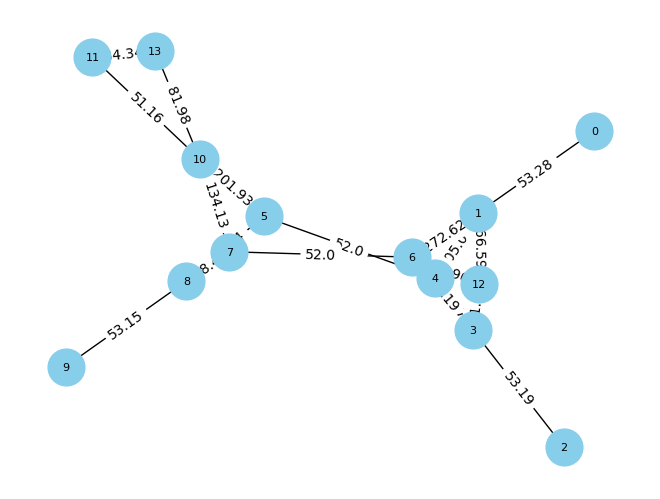

PathInfo(nodes=[12, 4, 5, 10, 13, 14], edges=[121.92, 52.0, 201.93, 81.98], costs=[121.92, 52.0, 201.93, 81.98], total_cost=457.83000000000004)


In [23]:
global_navigation()

In [30]:
from tdmclient import ClientAsync, aw

In [31]:
#Create a Client Object:
client = ClientAsync()
print(client)

In [32]:

client.process_waiting_messages()
print(client.nodes)


[Node aab42e35-3b95-4e21-ac5a-4296aadae5f2]


In [34]:
#while True:
print( client.nodes)
node = client.nodes[0]

[Node aab42e35-3b95-4e21-ac5a-4296aadae5f2]


In [35]:
aw(node.lock())

NodeLockError: Node lock error (current status: busy)

In [36]:
aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)
parameters = aruco.DetectorParameters()  
detector = aruco.ArucoDetector(aruco_dict, parameters)


In [37]:
    v = {
        "motor.left.target": [0],
        "motor.right.target": [0],
    }
    aw(node.set_variables(v))

{'error_code': 2}

In [38]:
def get_line():
    # Gets first start of line
    start_point = get_Thymio()
    start_foward = start_point[0]
    coords = []
    start_x = round((start_foward[0]))
    start_y = round((start_foward[1]))
    coords.append((start_x, start_y))
    # Get nodes
    for i in range(1, (len(shortest_path[0])-2)):
        coord_x = round(node_coord_x[shortest_path[0][i]])
        coord_y = round(node_coord_y[shortest_path[0][i]])
        coords.append((coord_x, coord_y))
        
    goal_point = get_goal()
    goal_x = round((goal_point[0]))
    goal_y = round((goal_point[1]))
    coords.append((goal_x, goal_y))
    return coords
        

In [39]:
def second_line():
    # Gets first start of line
    start_point = thymio_real_time(corners, ids)
    start_foward = start_point[0]
    coords = []
    start_x = round((start_foward[0]))
    start_y = round((start_foward[1]))
    coords.append((start_x, start_y))
    # Get nodes
    for i in range(1, (len(shortest_path[0])-2)):
        coord_x = round(node_coord_x[shortest_path[0][i]])
        coord_y = round(node_coord_y[shortest_path[0][i]])
        coords.append((coord_x, coord_y))
        
    goal_point = get_goal()
    goal_x = round((goal_point[0]))
    goal_y = round((goal_point[1]))
    coords.append((goal_x, goal_y))
    return coords
        

In [40]:
coords = get_line()
print(coords)

[(196, 231), (288, 151), (340, 150), (439, 326), (454, 246)]


In [41]:
def draw_line(coords):
    color = (255, 255, 255) 
    thickness = 9
    
    j = 1
    for i in range(len(coords)-1):
        start_point = coords[i]
        end_point = coords[j]
        cv2.line(frame, start_point, end_point, color, thickness) 
        j = j+1

In [42]:
def second_draw(coords):
    color = (0, 0, 0) 
    thickness = 9
    
    j = 1
    for i in range(len(coords)-1):
        start_point = coords[i]
        end_point = coords[j]
        cv2.line(frame, start_point, end_point, color, thickness) 
        j = j+1

Notes: We will need to add local navigation and kidnapping

In [44]:
import time
from IPython.display import clear_output


start_time=0
end_time=1

motor_command[2]=1
finished=0
thymio_coords=[[0,0],[0,0]]
proxmity_sensors=[0,0,0,0,0,0,0]

cap = cv2.VideoCapture(1, cv2.CAP_DSHOW)  # Use 0 if you have only one camera

holder = [[0,0],[0,0]]
current_goal=1

acceleration=0
global_navigation_kidnapping=0
kidnap_active = 0
timer = 0

start_line = 0
while True:
    i = 0
    global thymio_coords

    
    end_time = time.perf_counter()
    time_period=end_time-start_time    #calculate the duration of 1 iteration of the loop to calculate integrals and derivatives in the controller
    start_time = time.perf_counter()


   
    
# --------------------------------------------------------------------------------------------------------#
# # # -------------------------------------- Displays live video ------------------------------------ # # #
# --------------------------------------------------------------------------------------------------------#

    
     # Read a frame from the camera
    ret, frame = cap.read()


    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Detect markers
    corners, ids, rejected_img_points = detector.detectMarkers(gray)
   
    if np.all(ids is not None):
        for i in range(len(ids)):
            aruco.drawDetectedMarkers(frame, corners, ids)
            
    # This draws the very initial line     
    if start_line == 0:
        coords = get_line() 
        draw_line(coords)
    else:
        # NOTE: In order to work we will need to pass in thymio coords
#         coords = second_line()
#         second_draw(coords)
    
    # Display the frame
    cv2.imshow('frame', frame)

   
    
# --------------------------------------------------------------------------------------------------------#
# # # -------------------------------------- Update Thymio coords ----------------------------------- # # #
# --------------------------------------------------------------------------------------------------------#
   
    
    idx_back = np.where(ids == 0)[0]
    idx_fowards = np.where(ids == 1)[0]

# ------------------------------- add kalman here --------------------------- #

    # Get current thymio_coords
    if np.any(idx_fowards):
        if np.any(idx_back):
            thymio_coords = thymio_real_time(corners, ids)    
    else:
        thymio_coords = holder

        
        
# --------------------------------------------------------------------------------------------------------#
# # # -------------------------------------- kidnapping--------- ------------------------------------ # # #
# --------------------------------------------------------------------------------------------------------#    
    aw(node.wait_for_variables({"acc"}))
    acceleration=list(node.v.acc)
    
    print("timer")
    print(timer)
    if acceleration[2]>26:          #detection of kidnapping with accelerometer
        v = {
        "motor.left.target": [0],
        "motor.right.target": [0],
        }
        aw(node.set_variables(v))
        
        current_goal=1
      
        kidnap_active = 1

        print("KIDNAPPED!")
       #time.sleep(3)                     #delay to have time to move the robot
        #global_navigation_kidnapping=1


    if kidnap_active == 1:
        timer = timer + 1
    if timer == 30:
    # ------------------------------- add kalman here --------------------------- #
        if np.any(idx_fowards):
            if np.any(idx_back):
                thymio_coords = thymio_real_time(corners, ids)    
        else:
            thymio_coords = holder
        print("DONE KIDNAPPING")
        global_navigation_real_time(corners,ids, thymio_coords,center_goal,obstacle_coord)   #recomputin the global path after kidnapping
        coords = get_line() 
        draw_line(coords)
        start_line = 1
        kidnap_active = 0
        timer = 0
# --------------------------------------------------------------------------------------------------------#
# # # -------------------------------------- Filter ------------------------------------------------- # # #
# --------------------------------------------------------------------------------------------------------#
    
   
    

# --------------------------------------------------------------------------------------------------------#
# # # -------------------------------------- Local Navigation --------------------------------------- # # #
# --------------------------------------------------------------------------------------------------------#

    
    aw(node.wait_for_variables({"prox.horizontal"}))   #updating the proximity sensors for the local avoidance
    proximity_sensors=list(node.v.prox.horizontal)


# --------------------------------------------------------------------------------------------------------#
# # # -------------------------------------- Controller --------------------------------------------- # # #
# --------------------------------------------------------------------------------------------------------#
    
    if finished!=1:  
        motor_command = controller(thymio_coords, current_goal, time_period, proximity_sensors)   #new motor speed calculated by the controller
        motor_left = motor_command[0]
        motor_right = motor_command[1] 
        
    if motor_command[2]==0:  #if current_goal is met, switching to the next goal and resetting the flag  
        current_goal+=1
        motor_command[2]=1  
        
        if shortest_path[0][current_goal]==offset+2:  #if the final goal is attained, stop the robot
            motor_left = 0
            motor_right = 0
            finished=1
            print("FINISHED")
            v = {
                "leds_top": [0,30,0],
            }
            aw(node.set_variables(v))
           
    
        

# --------------------------------------------------------------------------------------------------------#
# # # -------------------------------------- Set Thymio motors -------------------------------------- # # #
# --------------------------------------------------------------------------------------------------------#
    # Setting motors
    # If kidnapped
    if kidnap_active == 1:
        v = {
        "motor.left.target": [0],
        "motor.right.target": [0],
        }
        aw(node.set_variables(v))

    else:
        v = {
            "motor.left.target": [motor_left],
            "motor.right.target": [motor_right],
        }
        aw(node.set_variables(v))


    # Check for the 'q' key to exit the loop
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        v = {
            "motor.left.target": [0],
            "motor.right.target": [0],
        }
        aw(node.set_variables(v))

        break
        
    holder = thymio_coords
    clear_output(wait=True)

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()
    

TypeError: 'NoneType' object is not subscriptable